In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pathlib import Path


plt.style.use('dark_background')

In [3]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda:0")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    device = torch.device("cpu")
print(f"Using device: {device}")

data_dir = Path(r"/mnt/c/Users/saulg/Desktop/dl_datasets/airline_passengers_ts")

GPU is available!
Using device: cuda:0


In [4]:
df_raw = pd.read_csv(data_dir / "airline-passengers.txt")
print(df_raw.dtypes)
df_raw.head()

Month         object
Passengers     int64
dtype: object


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
# Convert the "Month" column to a datetime object
df_raw["Month"] = pd.to_datetime(df_raw["Month"], format="%Y-%m")

# Set the "Month" column as the index
df_raw.set_index("Month", inplace=True)
df_raw.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


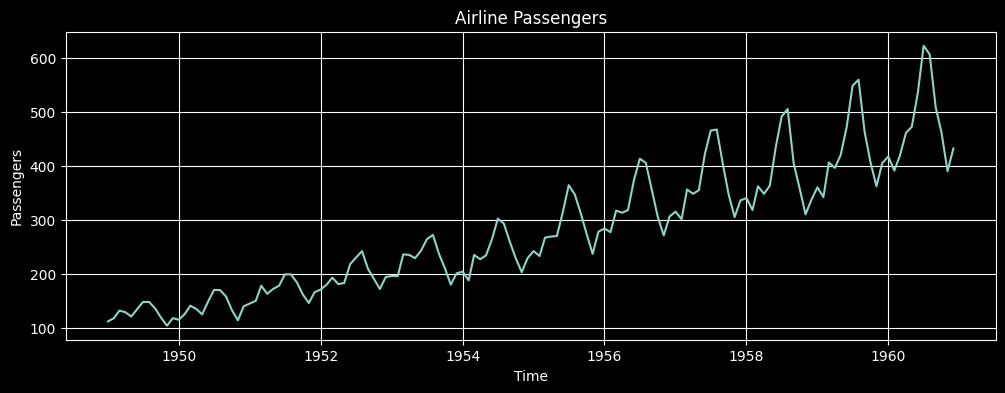

In [6]:
 # convert to float32 because PyTorch only accepts float32 for inputs
timeseries = df_raw.copy()
timeseries["Passengers"] = timeseries["Passengers"].values.astype("float32")

plt.figure(figsize=(12, 4))
plt.plot(timeseries.index, timeseries["Passengers"], label="Passengers")
plt.title("Airline Passengers")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

In [7]:
# Split into train and test sets
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries.iloc[0:train_size], timeseries.iloc[train_size:len(timeseries)]

In [8]:
def create_timeseries_dataset(dataset, lookback, lookahead=1):
    """Transform a timeseries into samples of X and y"""
    x = []
    y = []
    n_samples = len(dataset) - lookback
    for i in range(n_samples):
        feature = dataset[i:(i + lookback)]
        target = dataset[i+lookback:i+lookback+lookahead]
        x.append(feature)
        y.append(target)
    return np.array(x), np.array(y)

In [9]:
lookback = 1
x_train, y_train = create_timeseries_dataset(train, lookback=lookback)
x_test, y_test = create_timeseries_dataset(test, lookback=lookback)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (95, 1, 1)
Shape of y_train: (95, 1, 1)
Shape of x_test: (47, 1, 1)
Shape of y_test: (47, 1, 1)


In [10]:
# convert to PyTorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [11]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [12]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(x_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(x_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.9176, test RMSE 422.3434
Epoch 100: train RMSE 191.4193, test RMSE 386.2812
Epoch 200: train RMSE 161.9751, test RMSE 354.7956
Epoch 300: train RMSE 135.9179, test RMSE 325.8665
Epoch 400: train RMSE 113.1609, test RMSE 298.9172
Epoch 500: train RMSE 94.5537, test RMSE 274.1993
Epoch 600: train RMSE 78.2847, test RMSE 250.8250
Epoch 700: train RMSE 64.2422, test RMSE 228.5043
Epoch 800: train RMSE 53.1145, test RMSE 207.9490
Epoch 900: train RMSE 44.3100, test RMSE 189.3546
Epoch 1000: train RMSE 37.6979, test RMSE 172.6246
Epoch 1100: train RMSE 33.8084, test RMSE 158.2011
Epoch 1200: train RMSE 29.8315, test RMSE 145.6427
Epoch 1300: train RMSE 27.8476, test RMSE 135.7636
Epoch 1400: train RMSE 27.1040, test RMSE 127.0951
Epoch 1500: train RMSE 25.6780, test RMSE 121.4174
Epoch 1600: train RMSE 24.7686, test RMSE 116.1843
Epoch 1700: train RMSE 24.4298, test RMSE 112.2873
Epoch 1800: train RMSE 24.1911, test RMSE 108.9704
Epoch 1900: train RMSE 24.3246, test R

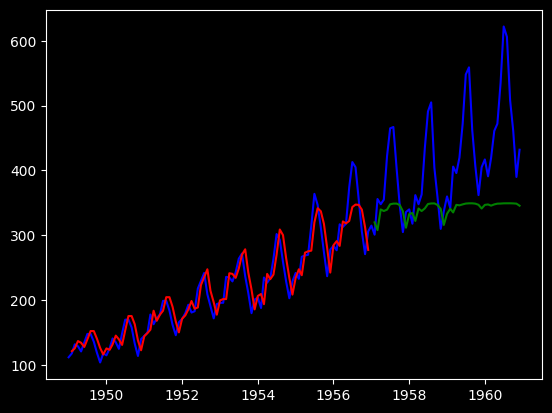

In [13]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(x_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(x_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(x_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(timeseries.index[0:len(train_plot)], train_plot, c='r')
plt.plot(timeseries.index[-len(train_plot)::], test_plot, c='g')
plt.show()